#Import Dependencies

In [ ]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#Load and Explore Dataset

170508288/170498071 [==============================] - 13s 0us/step


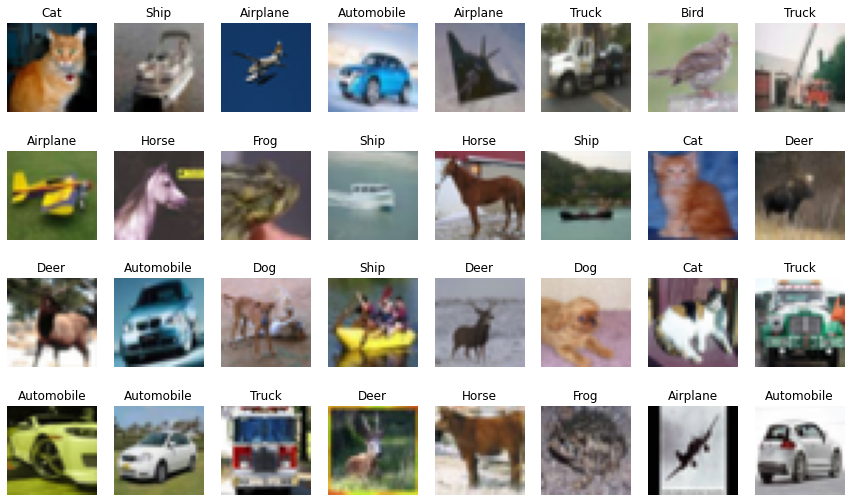

In [ ]:
#Since the Cifar10 dataset is available in keras, we'll load it from there
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

#Number of classes in the dataset
num_classes = 10

#Shape of the images
shape=(32,32,3)

#Cifar10 Classes
classes = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

#Displaying some random images from the dataset
Rows, Cols= 4, 8

#Create empty figure grid
fig = plt.figure(figsize=(2 * Cols - 1, 2.5 * Rows - 1))

#Iterate over the created grid
for i in range(Cols):
  for j in range(Rows):
    #Pick random index
    ind = random.randint(0, len(y_train))
    ax = fig.add_subplot(Rows, Cols, i * Rows + j + 1)
    ax.axis('off')
    #Display the image and corresponding class
    ax.imshow(x_train[ind, :])
    plt.title(classes[y_train[ind][0]])

#Data Preprocessing

In [ ]:
#Enocde the labels using one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Convert the pixels values to floats for better calculations
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Data Augmentation using data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

#Test dataset generator
test_datagen = ImageDataGenerator(rescale=1./255)

#Batch size
batch_size = 64

#Load training dataset to the generator
train_generator = train_datagen.flow(x_train, y_train,
                                     batch_size=batch_size)

#Load testing dataset to the generator
validation_generator = test_datagen.flow(x_test, y_test,
                                         batch_size=batch_size)

#Base Model

In [ ]:
#Constructing the base model using keras
base_model = tf.keras.models.Sequential(
    #First convolutional layer
    [tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=shape),
     tf.keras.layers.MaxPooling2D(2,2),
     #Second convolutional layer
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2), 
     #Dropout layer to prevent overfitting
     tf.keras.layers.Dropout(0.3),
     #Flattening before fully connected layer
     tf.keras.layers.Flatten(), 
     #Fully connected layer
     tf.keras.layers.Dense(128, activation='relu'), 
     tf.keras.layers.Dropout(0.3),
     #Classification layer
     tf.keras.layers.Dense(num_classes, activation='softmax')  
     ])

#Print model summary
base_model.summary()


In [ ]:
#Number of iterations to train the model
epochs = 60

#Model compilation
base_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

#Model training
history = base_model.fit(train_generator,
                         epochs=epochs,
                         validation_data=validation_generator,
                         batch_size = batch_size,
                         steps_per_epoch = len(x_train) // batch_size,
                         verbose=2)

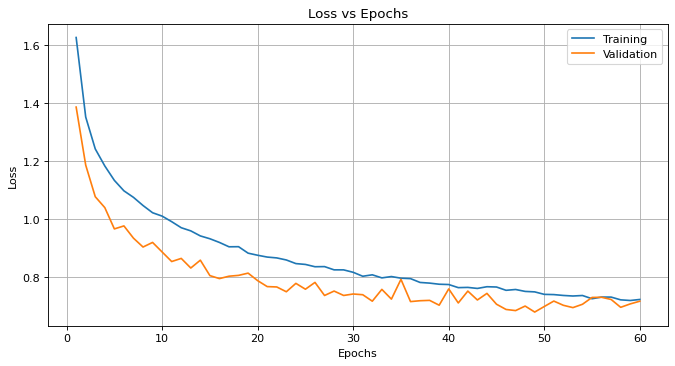

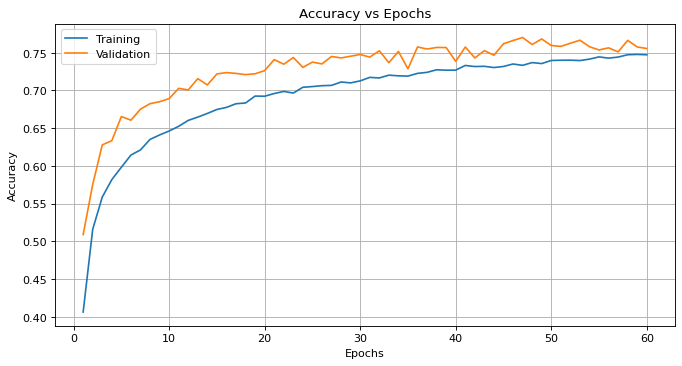

In [ ]:
#Plot training and validation loss
plt.figure(figsize=(10,5), dpi = 80)
#Epoch range
Epochs_range = np.linspace(1, epochs, epochs)
plt.plot(Epochs_range, history.history['loss'])
plt.plot(Epochs_range, history.history['val_loss'])
plt.grid()
#Label the figures
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['Training', 'Validation'])

#Plot training and validation accuracy
plt.figure(figsize=(10,5), dpi = 80)
plt.plot(Epochs_range, history.history['accuracy'])
plt.plot(Epochs_range, history.history['val_accuracy'])
plt.grid()
#Label the figures
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['Training', 'Validation'])

#Optimized Model

In [ ]:
#Create the regulizers object
regularizer = regularizers.l2(1e-4)

#Construct model using keras
opt_model = tf.keras.models.Sequential([
    #First convolutional layer
    tf.keras.layers.Conv2D(128, (3,3), activation= 'relu', kernel_regularizer=regularizer, input_shape=shape, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Dropout 
    tf.keras.layers.Dropout(0.3),
    #2nd, 3rd, 4th and 5th convolutional layer
    tf.keras.layers.Conv2D(256, (3,3), activation= 'relu', kernel_regularizer=regularizer, padding='same'),
    tf.keras.layers.Conv2D(512, (3,3), activation= 'relu', kernel_regularizer=regularizer, padding='same'),
    tf.keras.layers.Conv2D(512, (3,3), activation= 'relu', kernel_regularizer=regularizer, padding='same'),
    tf.keras.layers.Conv2D(256, (3,3), activation= 'relu', kernel_regularizer=regularizer, padding='same'),
    tf.keras.layers.Dropout(0.3),
    #Flatten the output from convolutional block
    tf.keras.layers.Flatten(), 
    #1st, 2nd and 3rd fully connected layers
    tf.keras.layers.Dense(512, activation= 'relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation= 'relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation= 'relu'), 
    tf.keras.layers.Dropout(0.5),
    #Classification layer
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])

#Print model summary
opt_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 512)       1180160   
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 512)       2359808   
                                                      

In [ ]:
#Set learning rate for the optimizer
lr = 3e-4

#Set weight decay
weight_decay = 1e-6

#Model compilation
opt_model.compile(optimizer=Adam(learning_rate=lr, decay=weight_decay),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

#Model training
history = opt_model.fit(train_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        batch_size = batch_size,
                        steps_per_epoch = len(x_train) // batch_size,
                        verbose=2)

#Save trained model
opt_model.save('Trained_Model.h5')

Epoch 1/60
781/781 - 50s - loss: 2.1402 - accuracy: 0.1930 - val_loss: 1.7179 - val_accuracy: 0.3639 - 50s/epoch - 64ms/step
Epoch 2/60
781/781 - 47s - loss: 1.6706 - accuracy: 0.3807 - val_loss: 1.4039 - val_accuracy: 0.4781 - 47s/epoch - 60ms/step
Epoch 3/60
781/781 - 48s - loss: 1.4615 - accuracy: 0.4743 - val_loss: 1.2672 - val_accuracy: 0.5394 - 48s/epoch - 61ms/step
Epoch 4/60
781/781 - 47s - loss: 1.3432 - accuracy: 0.5254 - val_loss: 1.1588 - val_accuracy: 0.5904 - 47s/epoch - 61ms/step
Epoch 5/60
781/781 - 48s - loss: 1.2646 - accuracy: 0.5580 - val_loss: 1.0821 - val_accuracy: 0.6242 - 48s/epoch - 61ms/step
Epoch 6/60
781/781 - 47s - loss: 1.2096 - accuracy: 0.5838 - val_loss: 1.0664 - val_accuracy: 0.6332 - 47s/epoch - 61ms/step
Epoch 7/60
781/781 - 47s - loss: 1.1473 - accuracy: 0.6074 - val_loss: 1.0247 - val_accuracy: 0.6559 - 47s/epoch - 60ms/step
Epoch 8/60
781/781 - 47s - loss: 1.0973 - accuracy: 0.6294 - val_loss: 1.0040 - val_accuracy: 0.6558 - 47s/epoch - 61ms/step


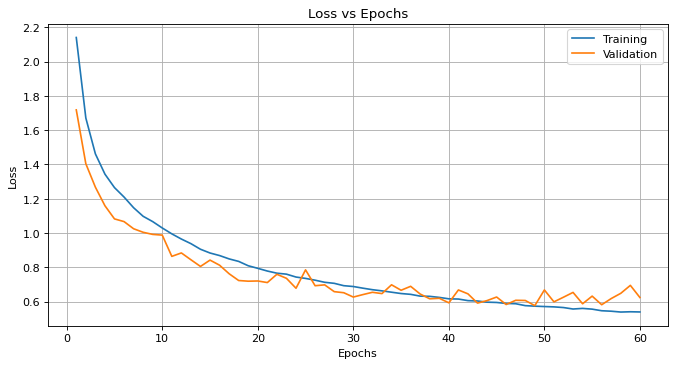

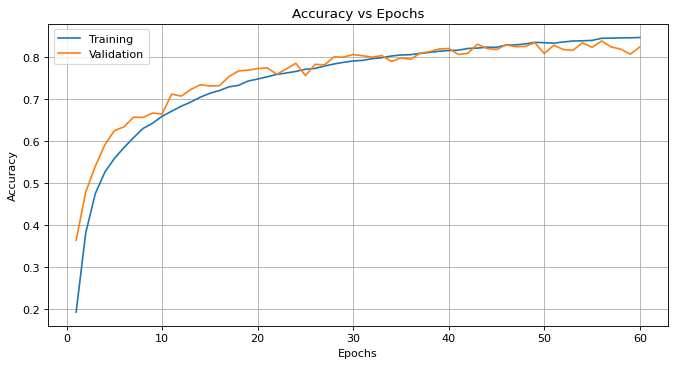

In [ ]:
#Plot training and validation loss
plt.figure(figsize=(10,5), dpi = 80)
plt.plot(Epochs_range, history.history['loss'])
plt.plot(Epochs_range, history.history['val_loss'])
plt.grid()
#Label the figures
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['Training', 'Validation'])

#Plot training and validation accuracy
plt.figure(figsize=(10,5), dpi = 80)
plt.plot(Epochs_range, history.history['accuracy'])
plt.plot(Epochs_range, history.history['val_accuracy'])
plt.grid()
#Label the figures
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['Training', 'Validation'])

#Model Evaluation and Predictions

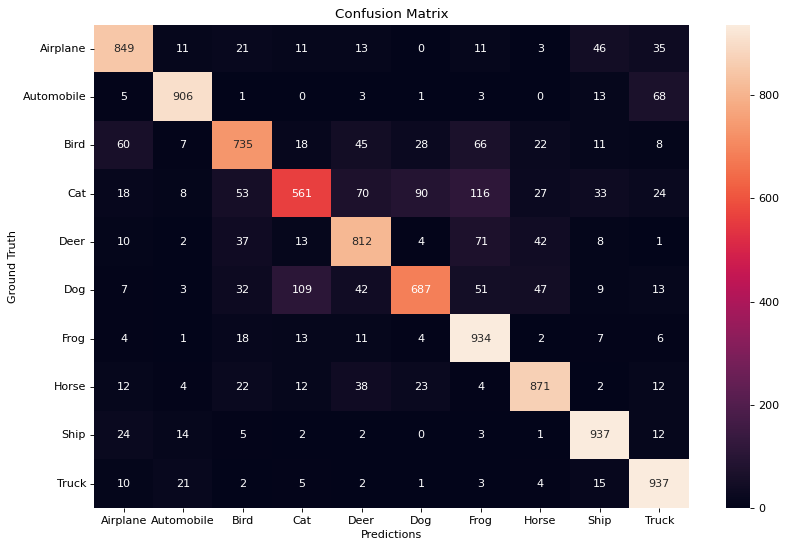

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.93      0.91      0.92      1000
           2       0.79      0.73      0.76      1000
           3       0.75      0.56      0.64      1000
           4       0.78      0.81      0.80      1000
           5       0.82      0.69      0.75      1000
           6       0.74      0.93      0.83      1000
           7       0.85      0.87      0.86      1000
           8       0.87      0.94      0.90      1000
           9       0.84      0.94      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
#Model prediction on test data
y_pred = opt_model.predict(x_test/255.0)

#Get prediction classes
y_pred_classes = np.argmax(y_pred, axis=1)

#Get prediction probabilities
y_pred_prob = np.max(y_pred, axis=1)

#Get original labels from encoded ones
y_test = np.argmax(y_test, axis=1)

#Calculate model confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

#Plot model confusion matrix
plt.figure(figsize=(12, 8),dpi=80)
sns.heatmap(conf_matrix,
            xticklabels=list(classes.values()),
            yticklabels=list(classes.values()),
            annot=True,
            fmt='d')
#Label the plot
plt.title('Confusion Matrix')
plt.ylabel('Ground Truth')
plt.xlabel('Predictions')
plt.show()

#Print classification report
print(classification_report(y_test, y_pred_classes))

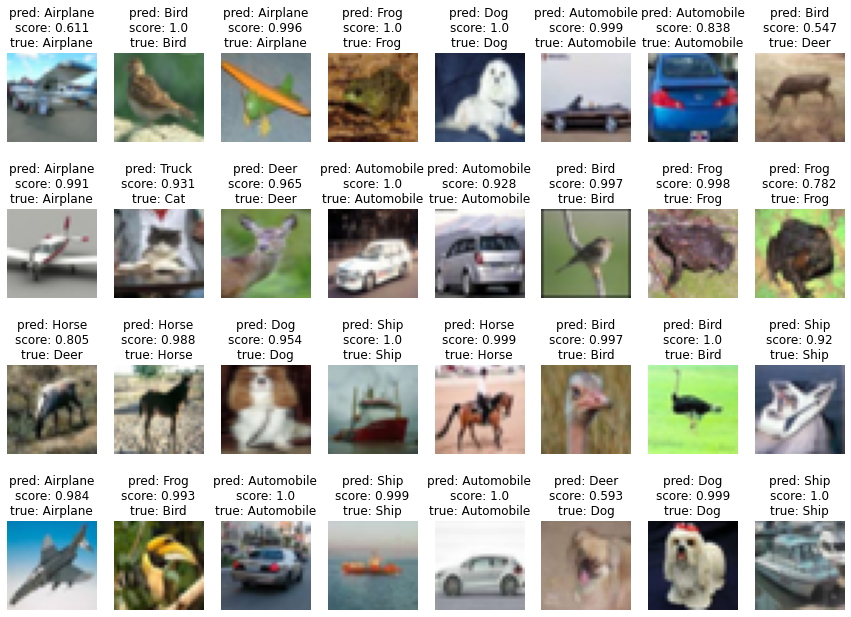

In [ ]:
#Plot model predicitons with true labels
fig = plt.figure(figsize=(2 * Cols - 1, 3 * Rows - 1))
#Iterate over the grid
for i in range(Cols):
  for j in range(Rows):
    #Get random index
    ind = random.randint(0, len(y_test))
    ax = fig.add_subplot(Rows, Cols, i * Rows + j + 1)
    ax.axis('off')
    #Display the image
    ax.imshow(x_test.astype(int)[ind])
    #Print original class with prediction class and probability
    pred_label = classes[y_pred_classes[ind]]
    pred_proba = y_pred_prob[ind]
    true_label = classes[y_test[ind]]
    ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
            pred_label, pred_proba, true_label))
plt.show()